# Importing libraries and downloading dataset

In [2]:
import glob
import cv2
import torch.nn as nn 
import os
import torch
import copy
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# Hyperparameters

In [3]:
batch_size = 4

In [4]:
# path = kagglehub.dataset_download("nickj26/places2-mit-dataset") + 'versions/2/test_256/test_256'
train_path = '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train'
test_path = '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/test'
print("Path to dataset files:", train_path)

Path to dataset files: /home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train


## Size of training batch

In [5]:
file_names = glob.glob(train_path + '/*.jpg')

print(len(file_names))
print(file_names[:10])

328168
['/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00067829.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00005034.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00241834.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00017812.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00203406.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00184281.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00317614.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00299825.jpg', 

# Data preprocessing

In [6]:
class Placesdataset(Dataset):
    def __init__(self, dir_path, image_dim=(256,256),n_channels=3, mask_iterations = 5):
        self.file_names = glob.glob(dir_path + '/*.jpg')
        self.img_dim = image_dim
        self.to_tensor = transforms.ToTensor()
        self.channels = n_channels
        self.iterations = mask_iterations
        self.resize = transforms.Resize(image_dim)

    def __getitem__(self, idx):
        image = Image.open(self.file_names[idx]).convert("RGB")
        Y_output = self.resize(image)
        X_input, X_mask = self.create_mask(Y_output)
        X_input = self.to_tensor(X_input)
        X_mask = self.to_tensor(X_mask)
        Y_output = self.to_tensor(Y_output)
        return X_input, X_mask, Y_output

        

    def __len__(self):
        return len(self.file_names)
    
    def line_generator(self, image):
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            pt2 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            thickness =np.random.randint(10, 15)
            
            cv2.line(image, pt1=pt1, pt2=pt2, color=(1,1,1), thickness=thickness)

    def circle_generator(self, image):
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            radius =np.random.randint(5, 25)

            cv2.circle(image,pt1,radius,(1,1,1), -1)

    def create_mask(self, image):
        mask = np.full((self.img_dim[0], self.img_dim[1], self.channels), 255, dtype=np.uint8)
        self.line_generator(mask)
        self.circle_generator(mask)

        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask

In [7]:
Training_Data = Placesdataset(train_path)

Training_Loader = torch.utils.data.DataLoader(Training_Data, batch_size, shuffle=True)

Train_Iter = iter(Training_Loader)


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
Masked Image


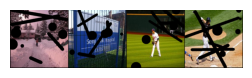

Masking Pattern


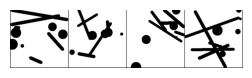

Original Image


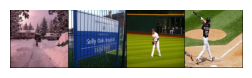

In [8]:
X_in, X_mask, Y_out = Train_Iter._next_data()
print(X_in.shape, X_mask.shape, Y_out.shape)

def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# Model Architecture

![Architecture](Places-2-network-architecture.png)

## Network

In [9]:
class Partial_Conv(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size=(3,3),stride=1, bias=True, groups=1,dilation=1, bn=True):
        super().__init__()
        self.bn = bn
        padding = (kernel_size[0]//2, kernel_size[1]//2)
        self.input_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups,bias)
        self.mask_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups, False)

        self.window_size = kernel_size[0]*kernel_size[1]
        nn.init.constant_(self.mask_conv.weight, 1.0)
        nn.init.kaiming_normal_(self.input_conv.weight, a = 0, mode='fan_in')

        if self.bn:
            self.bath_normalization = nn.BatchNorm2d(output_filters)
        for param in self.mask_conv.parameters():
            param.requires_grad = False
    
    def forward(self, input, mask):
        output = self.input_conv(input * mask)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)
        output_mask = torch.clamp(output_mask, 0, 1)
        mask_ratio = mask_ratio * output_mask
        output = output * mask_ratio


        return output, output_mask

In [10]:
class EncodingLayer(nn.Module):
    def __init__(self, in_filters, out_filters, kernel=3, stride=1, bias=False, bn=True):
        super().__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.activation = nn.ReLU()
        self.conv = Partial_Conv(self.in_filters, self.out_filters,(kernel,kernel),stride, bias = bias, bn=bn)

    def forward(self, input, input_mask):
        output, output_mask = self.conv(input, input_mask)
        output = self.activation(output)
        return output, output_mask


In [11]:
class DecodingLayer(nn.Module):
    def __init__(self, in_filters, out_filters, bn=True, activation=True, bias=False):
        super().__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.up_image = nn.Upsample(scale_factor=(2,2))
        self.up_mask = nn.Upsample(scale_factor=(2,2))
        self.activate = activation
        self.conv = Partial_Conv(self.in_filters, self.out_filters, bias=bias,bn=bn)
        self.act = nn.LeakyReLU(negative_slope=0.2)
    
    def forward(self, input_image, input_mask, shared_image, shared_mask):
        upscaled_image = F.interpolate(input_image, scale_factor=2)
        upscaled_mask = F.interpolate(input_mask, scale_factor=2)
        combined_image = torch.cat([upscaled_image, shared_image], dim=1)
        combined_mask = torch.cat([upscaled_mask, shared_mask], dim=1)
        output_image, output_mask = self.conv(combined_image, combined_mask)
        if self.activate:
            output_image = self.act(output_image)
        return output_image, output_mask


    


In [12]:
class PartialConvUNet(nn.Module):
    def __init__(self, input_size = 256, layers = 7):
        if 2**(layers + 1) != input_size:
            raise AssertionError
        super().__init__()
        self.layers = layers 
        self.encoder_1 = EncodingLayer(3, 64, 7, 2, bn=False)
        self.encoder_2 = EncodingLayer(64, 128, 5, 2)
        self.encoder_3 = EncodingLayer(128, 256, 3, 2)
        self.encoder_4 = EncodingLayer(256, 512, 3, 2)

        for i in range(5, layers + 1):
            name = f"encoder_{i}"
            setattr(self, name, EncodingLayer(512, 512, 3, 2))

        for i in range(5, layers + 1):
            name = f"decoder_{i}"
            setattr(self, name, DecodingLayer(512+512, 512))

        self.decoder_4 = DecodingLayer(512 + 256, 256)
        self.decoder_3 = DecodingLayer(256 + 128, 128)
        self.decoder_2 = DecodingLayer(128 + 64, 64)
        self.decoder_1 = DecodingLayer(64 + 3, 3, bn=False, activation=False, bias=True)

    def forward(self, input_x, mask):
        encoder_dict = {}
        mask_dict = {}
        key_prev = "h_0"
        encoder_dict[key_prev], mask_dict[key_prev] = input_x, mask

        for i in range(1, self.layers + 1):
            encoder_key = f'encoder_{i}'
            key = f"h_{i}"
            encoder_dict[key], mask_dict[key] = getattr(self, encoder_key)(encoder_dict[key_prev], mask_dict[key_prev])
            key_prev = key
        
        out_key = f"h_{self.layers}"
        out_data, out_mask = encoder_dict[out_key], mask_dict[out_key]

        for i in range(self.layers, 0, -1):
            encoder_key = f"h_{i-1}"
            decoder_key = f"decoder_{i}"
            out_data, out_mask = getattr(self, decoder_key)(out_data, out_mask, encoder_dict[encoder_key], mask_dict[encoder_key])
        return out_data



        

## Loss function

In [13]:
class LossFunction(nn.Module):
    def __init__(self, extractor):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.extractor = extractor
    
    def gram_matrix(self, feat):

        (b, ch, h, w) = feat.size()
        feat = feat.view(b, ch, h * w)
        feat_t = feat.transpose(1,2)
        gram = torch.bmm(feat, feat_t) / (ch * h * w)
        return gram

    def total_var_loss(self, image):
        # shift one pixel and get difference (for both x and y)
        loss = torch.mean(torch.abs(image[:,:,:,:-1] - image[:,:,:,1:])) + \
            torch.mean(torch.abs(image[:,:,:-1,:] - image[:,:,1:,:]))
        return loss
    

    def forward(self, input, mask, output, original):
        loss_dict = {}
        output_comp = mask * input + (1 - mask) * output
        loss_dict['hole'] = self.l1((1 - mask) * output, (1 - mask) * original)
        loss_dict['valid'] = self.l1(mask * output, mask * original)

        feat_output_comp = self.extractor(output_comp)
        feat_output = self.extractor(output)
        feat_original = self.extractor(original)

        loss_dict['prc'] = 0.0
        for i in range(3):
            loss_dict['prc'] += self.l1(feat_output[i], feat_original[i])
            loss_dict['prc'] += self.l1(feat_output_comp[i], feat_original[i])

        loss_dict['style'] = 0.0
        for i in range(3):
            loss_dict['style'] += self.l1(self.gram_matrix(feat_output[i]),
                                          self.gram_matrix(feat_original[i]))
            loss_dict['style'] += self.l1(self.gram_matrix(feat_output_comp[i]),
                                          self.gram_matrix(feat_original[i]))
            
        loss_dict['tv'] = self.total_var_loss(output_comp)

        return loss_dict



## VGG16 Feature Extraction

In [14]:
class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16 = torchvision.models.vgg16(weights='DEFAULT')
        self.enc_1 = nn.Sequential(*vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        for i in range(3):
            for param in getattr(self, f'enc_{i+1}').parameters():
                param.requires_grad = False

    def forward(self, image):
        results = [image]
        for i in range(3):
            func = getattr(self, f'enc_{i+1}')
            results.append(func(results[-1]))

        return results[1:]

In [15]:
model = PartialConvUNet().to(device)
extractor = VGG16FeatureExtractor().to(device)
loss_fn = LossFunction(extractor).to(device)
opt = torch.optim.Adam(model.parameters())
LAMBDA_DICT = {
    'valid': 1.0, 'hole': 6.0, 'tv': 0.1, 'prc': 0.05, 'style': 120.0}

loss_arr = []
max_epochs = 1
min_loss = 1000
n_iters = np.ceil(len(Training_Loader))
for epoch in range(max_epochs):
    model.train()
    for i, (x_input, x_mask, y_output) in enumerate(Training_Loader):
        x_input, x_mask, y_output = x_input.to(device), x_mask.to(device), y_output.to(device)
        opt.zero_grad()

        output_img = model(x_input, x_mask)
        loss_dict = loss_fn(x_input, x_mask, output_img, y_output)
        loss = 0.0
        for key, coef in LAMBDA_DICT.items():
            value = coef * loss_dict[key]
            loss += value
            if (i + 1) % 100 == 0:
                string = f'loss_{key}'
                print(f'{string:<10}',": ", f"{value.item():.5f}",f"Batch: {i + 1}")

        loss.backward()
        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print(f'Min loss: {min_loss:.5f}')

        if (i + 1) % 100 == 0:
            loss_arr.append(loss.item())

plt.plot(loss_arr)
plt.show()


Min loss: 2.77902
Min loss: 2.76471
Min loss: 2.71356


KeyboardInterrupt: 

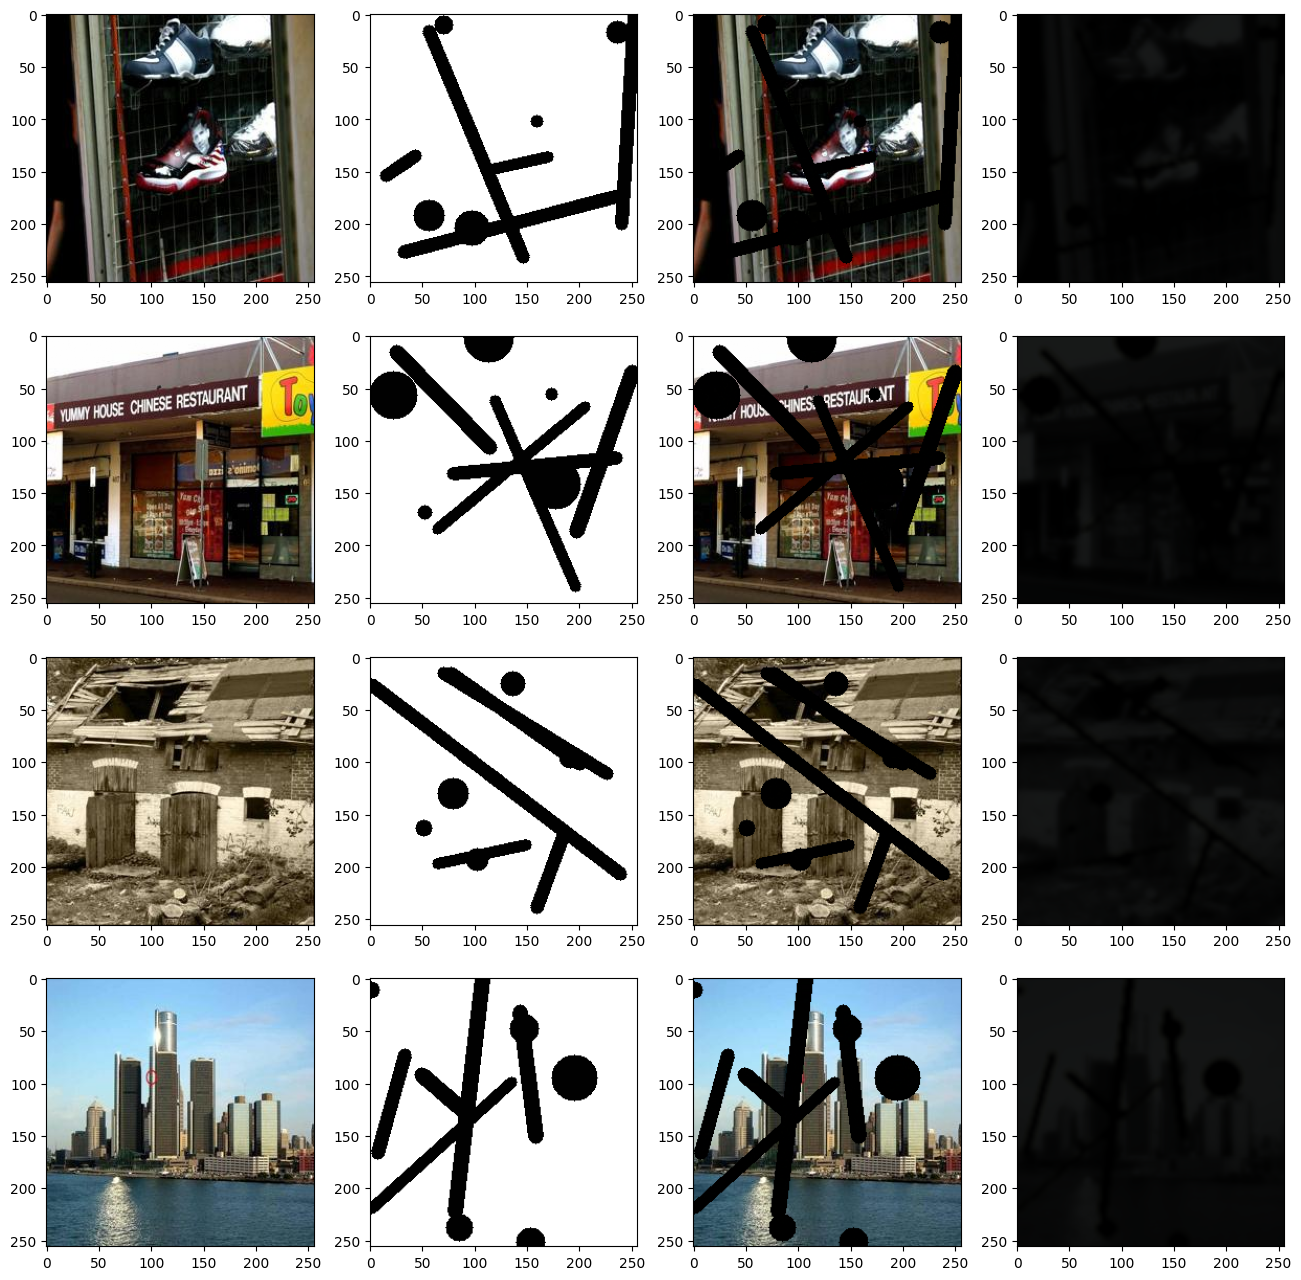

In [16]:
model.load_state_dict(best_model)

sample_inputs, sample_masks, sample_truths = Train_Iter._next_data()
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))


In [17]:

filename = "models/256resoModel_dict"
saving = False
if saving:
    model.load_state_dict(best_model)
    torch.save(model, filename)

# Locally Trained model

/tmp/ipykernel_8279/3685014559.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model= torch.load('models/256resoModel_dict')
Clipping input data to the valid range for i

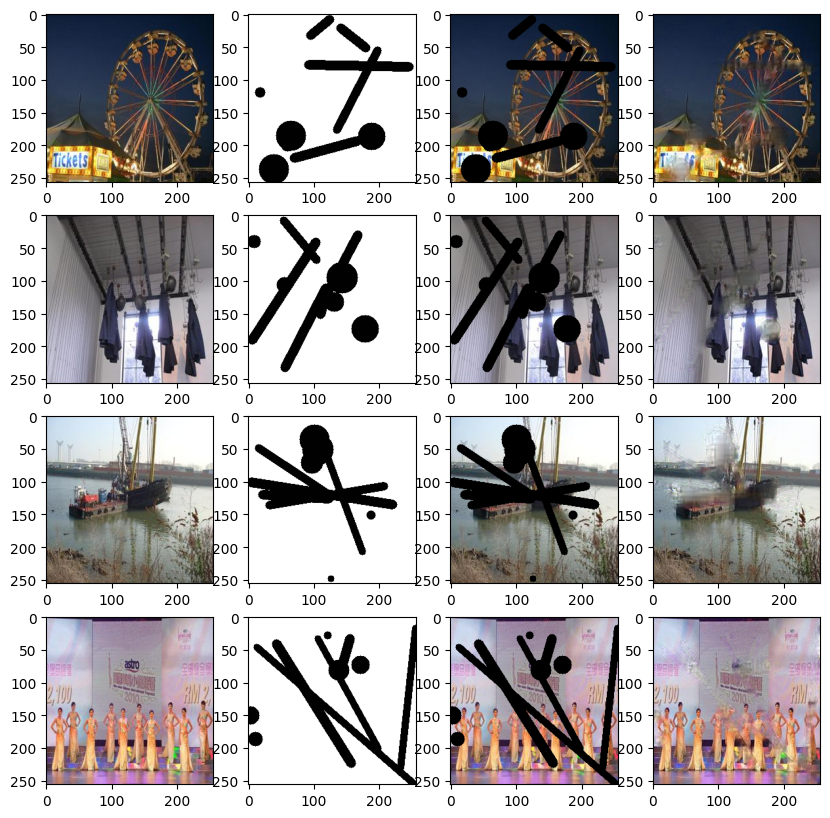

In [18]:
import pickle
model= torch.load('models/256resoModel_dict')

sample_inputs, sample_masks, sample_truths = Train_Iter._next_data()
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

# Kaggle output model testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6840739..1.1427912].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09736602..1.0836474].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08100955..1.105483].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.101471774..1.5690026].


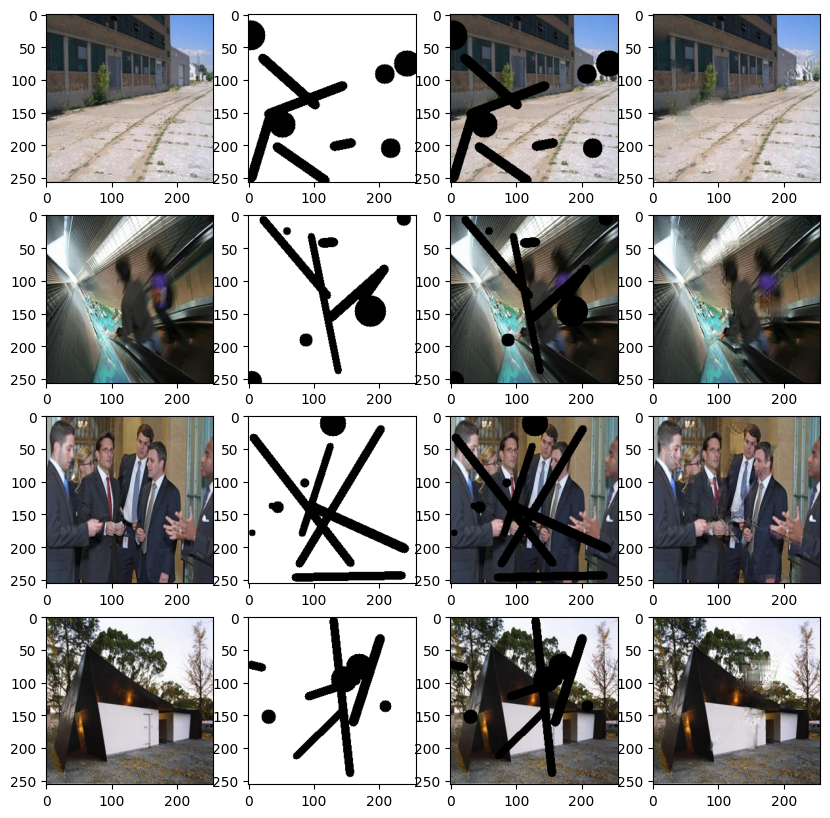

In [21]:
model = PartialConvUNet().to(device)
model.load_state_dict(torch.load("models/ImageInpainting600k.pt", weights_only=True))
sample_inputs, sample_masks, sample_truths = Train_Iter._next_data()
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

In [22]:
evaluating = True
# Ensure an output directory exists
os.makedirs("test_output_images", exist_ok=True)

# Iterate through batches to process 200 images
for batch_idx in range(50):  # 50 batches x 4 images = 200 images
    # Unfortunately I first got outputs on the training data
    # working on a seperate notebook to get outputs on the testing directory
    sample_inputs, sample_masks, sample_truths = Train_Iter._next_data()
    sample_inputs, sample_masks = sample_inputs.to(device), sample_masks.to(device)
    
    with torch.no_grad():
        sample_preds = model(sample_inputs, sample_masks)
    
    sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
    
    for i in range(4):
        fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
        
        # Ground truth
        axs[0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
        axs[0].set_title("Ground Truth")
        axs[0].axis('off')

        # Mask
        axs[1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
        axs[1].set_title("Mask")
        axs[1].axis('off')

        # Input
        axs[2].imshow(np.transpose(sample_inputs[i], (1, 2, 0)))
        axs[2].set_title("Input")
        axs[2].axis('off')

        # Prediction
        axs[3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
        axs[3].set_title("Prediction")
        axs[3].axis('off')
        
        # Save image to disk
        output_path = f"test_output_images/batch_{batch_idx}_image_{i}.png"
    
        plt.savefig(output_path)
        plt.close(fig)
    print(f"{batch_idx}, done")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039219536..0.90067375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07463675..1.1725508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035523362..1.084997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07457974..1.2232476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08468896..1.0836756].


0, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10073829..1.220728].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17223783..1.3184826].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.094655015..1.1372658].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.064140916..1.140884].


1, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06394728..1.1888851].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.096672356..1.2557076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059498582..1.1314718].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24640839..1.2093427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12546374..1.092346].


2, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05750023..0.82160455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09566378..1.0838737].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.077484384..1.245487].


3, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08379342..1.2084336].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17875168..1.0319655].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0615299..1.1657789].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118277974..1.2287426].


4, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05753851..1.1652057].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026397847..1.1103941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025325986..1.1402689].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10890191..1.1031703].


5, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06773835..0.9789211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05598373..1.231886].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15457633..1.3691379].


6, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.106901616..1.2664037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08907888..1.2542937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12659211..1.51679].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048131257..1.0862098].


7, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11739767..1.3020418].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03231877..1.1362654].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046808794..1.2809614].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09320227..1.1880952].


8, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12558892..1.2774464].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025004659..1.1557852].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04768059..1.3595986].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05290226..1.0176264].


9, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12508763..1.1904061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03700408..1.1824429].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21147156..1.3731611].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06924656..1.2463408].


10, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09259227..1.3658625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013275119..1.0199335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06820579..1.4322237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08801348..1.8247598].


11, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.082950294..1.4559966].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2446738..1.1912879].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025502076..1.0293756].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1507395..1.0397589].


12, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057927333..0.9697374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0849142..1.0700792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.100155264..1.0688559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061573178..1.3329514].


13, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09307339..1.0389979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1116569..1.045458].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14963317..1.1651745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04104139..1.046662].


14, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06057088..1.059186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.066482246..1.2173083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14361826..1.0831478].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06524679..1.2126673].


15, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06808361..1.218343].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19265118..1.3795435].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.058661867..1.1292791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.099058054..1.1860594].


16, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12560582..1.1388514].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11140275..1.3242741].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044669975..1.1338124].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16441612..1.1330276].


17, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.119133085..1.204294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2050182..1.1753521].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19939175..1.2211531].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019731563..1.1873405].


18, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1503799..1.4132783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0079331035..1.060224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17805043..1.3955444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09001563..1.1019863].


19, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17086893..1.2000035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.062220566..1.2558405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20947456..1.2520716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022726227..0.89751697].


20, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06513052..1.0616109].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.098262966..1.0932515].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.189798..1.2340099].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.076506235..1.1589885].


21, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0767189..1.2002552].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15457322..1.0782441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13779218..1.1050386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06626133..1.3263497].


22, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13897355..1.0703188].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.117699906..1.33885].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13263097..1.1470876].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23658706..1.5606112].


23, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11099007..1.1587386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020712662..1.1116979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08973748..1.0383756].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11078978..1.124949].


24, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21096218..1.1139318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09159646..1.2467514].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11082848..1.3036919].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13512756..1.2009879].


25, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056774136..1.1939903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00875924..1.0930109].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0089102145..1.0789136].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11152334..1.1358848].


26, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04829616..1.0987006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05478728..1.286252].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14288634..1.2975563].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017044071..1.1707811].


27, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024282664..1.1109486].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.034718085..1.1144401].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08078388..1.1740752].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031274192..1.0111915].


28, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21550894..1.1978751].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.103098206..1.2794176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04662253..1.1314995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07777732..1.2638637].


29, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08190729..1.2353091].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.111002505..1.2059901].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11270086..1.2145083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19016351..1.1810486].


30, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.036274515..1.1605581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16757227..1.2002999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06549895..1.1851934].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.060124367..1.3881674].


31, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17483634..1.1218337].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0570003..1.0703398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021585178..1.2947634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06600158..1.1538768].


32, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10658808..1.3659285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15496473..1.2981443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1284946..1.4192314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04879948..0.76945746].


33, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14517593..1.2583082].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0820128..1.1091069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15691409..1.1355686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08646436..1.1142768].


34, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1603034..1.2890339].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06884308..1.0829217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.062375452..1.1339867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027668832..1.3178544].


35, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13860746..1.0775219].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0998098..1.0433601].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18527229..1.3183556].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09736038..1.2372589].


36, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03101553..1.2390233].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19950472..1.2013993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13401385..1.1951004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07325105..1.1145623].


37, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.112747274..1.1864599].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12382766..1.0849292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07418561..1.2821763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12648411..1.1712611].


38, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057064068..1.3473026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14690098..1.2883666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.075590104..1.0494245].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.107402004..1.4220167].


39, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18200772..1.5200905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044120137..1.1959406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11597662..1.3079929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06377718..1.3037214].


40, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14229104..1.1713231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.190888..1.2580448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10872971..1.3843565].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12252409..1.3598931].


41, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07490857..1.0977722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09956426..1.0519288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.036575284..1.1312568].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043822624..1.1206036].


42, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056808323..1.2789607].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.069300994..1.353888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15951526..1.080389].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19895324..1.1639837].


43, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031261466..1.1121142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17119251..1.4045295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10898867..0.78712445].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33350047..1.3359963].


44, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15221475..1.1823399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051467523..1.2001286].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0013146122..1.0573351].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03520317..1.1854091].


45, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1374786..1.0057088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.121889934..1.1711905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10802518..1.2076439].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.074198335..1.3724799].


46, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006265384..1.3428274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14623104..1.2326964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007803474..1.1533937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0699215..1.0493575].


47, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.060619503..1.2005192].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.095829666..1.3122193].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08535531..0.98300797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14259365..1.199607].


48, done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07401595..1.1016797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13175054..1.3198026].


49, done
